In [1]:
#Import packages
import datetime
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [83]:
#read in data
reddits = pd.read_csv('C://Users/bobal/Desktop/reddit_posts.csv')

In [84]:
#Strip white space fro  column name and drop any column with no nunique values
def clean_drop (data):
    data.columns = data.columns.str.strip()
    for col in data.columns:
        if data[col].nunique() ==0:
            data.drop(col, axis =1, inplace =True)
            
clean_drop (reddits)

### Model to predict the score of Reddit posts


In [85]:
#Remove all deleted reddits an reset index of new dataframe
reddits = reddits[reddits['ups'] != 0]
reddits = reddits[reddits['selftext']!='[deleted]']
reddits.reset_index(inplace=True)
reddits.drop('index', axis =1, inplace =True)

In [86]:
#Create datetime object
reddits['time_cst'] = reddits['created_utc'].apply(lambda x: time.strftime("%Y/%m/%d, %H:%M:%S", time.localtime(x)))
reddits.drop('created_utc', axis=1, inplace=True)

In [87]:
reddits.time_cst = pd.to_datetime(reddits['time_cst'])

In [88]:
#Set non false values of edited column to True
for idx, val in enumerate(reddits['edited']):
    if val != 'False':
        reddits['edited'].iloc[idx]=True

In [89]:
#Transform edited column to boolean
d = {True: True, 'False': False}
reddits['edited']=reddits['edited'].map(d)

In [90]:
subs = pd.get_dummies(reddits['subreddit'], drop_first =True, prefix ='subs')
reddits.drop('subreddit', axis=1, inplace =True)
edited = pd.get_dummies(reddits['edited'], drop_first=True)
reddits.drop('edited', axis =1, inplace =True)

In [92]:
#import packages for nlp
from sklearn.feature_extraction.text import TfidfVectorizer

In [93]:
from stop_words import get_stop_words

In [94]:
#Cretae custom stop words
custom_stop_words = ['00','00 00','00 00 00', '000','000 000','10']
stop_words = get_stop_words('en') + custom_stop_words

In [96]:
#instantiate Countvectorizer and count word occurence throught selftext corpus
tf = TfidfVectorizer(stop_words=stop_words, min_df=.005, ngram_range=(1,4))
tf.fit_transform(reddits['selftext'])

<18870x1890 sparse matrix of type '<type 'numpy.float64'>'
	with 717077 stored elements in Compressed Sparse Row format>

In [97]:
#Get feature names from Countvectorizer and stor them in names
names = tf.get_feature_names()
len(names)

1275

In [98]:
#Transform sparse matrix:names,into dense dataframe: features
features = pd.DataFrame(cv.transform(reddits['selftext']).todense(),columns=names)

In [99]:
#instantiate TfidfVectorizer and count word occurence throught selftext corpus
tf = TfidfVectorizer(stop_words=stop_words, min_df=.005, ngram_range=(1,4))
tf.fit_transform(reddits['title'])

<18870x1275 sparse matrix of type '<type 'numpy.int64'>'
	with 85455 stored elements in Compressed Sparse Row format>

In [100]:
#Get feature names from Countvectorizer and store them in titles
titles = cv.get_feature_names()
len(titles)

1275

In [101]:
#Transform sparse matrix: titles,into dense dataframe: title_features
title_features = pd.DataFrame(cv.transform(reddits['title']).todense(),columns=titles)

In [102]:
df=title_features.join(features, rsuffix='f')

In [103]:
#import packages for pca
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
svd.fit_transform(df)

array([[  5.20126180e-01,  -1.98262471e-01,   9.49366558e-02, ...,
         -3.24523936e-02,  -2.02409720e-02,  -1.71067695e-01],
       [  9.43295447e+00,  -6.92166734e+00,  -5.19194324e+00, ...,
         -1.17379002e+00,   3.26674163e-01,  -1.19311208e+00],
       [  1.89208120e+00,  -5.81300677e-01,   8.30510754e-01, ...,
          1.62168845e-01,   4.13716713e-01,  -3.57164492e-02],
       ..., 
       [  1.22169259e+00,  -4.28292373e-01,   4.57457769e-01, ...,
          1.62804513e-01,   2.62462597e-01,  -2.10644535e-01],
       [  1.32341454e+00,  -4.42144836e-01,   4.48940307e-01, ...,
         -5.05476467e-01,   5.36744826e-02,   6.17508165e-03],
       [  4.51377519e-01,  -1.28712644e-01,   1.73250344e-01, ...,
          1.82536944e-01,   1.65200122e-01,  -2.12929982e-02]])

Explained variance of the SVD step: 62%


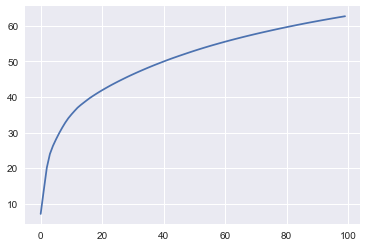

In [104]:
explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
int(explained_variance * 100)))

plt.plot(np.cumsum(svd.explained_variance_ratio_*100))
plt.show()

In [105]:
X=df.iloc[:,0:100]

In [106]:
X=X.join(reddits['num_comments'])

In [107]:
X=X.join(edited)

In [108]:
X= X.join(subs, rsuffix='sub')
y=reddits['ups']

In [109]:
X.shape, y.shape

((18870, 137), (18870L,))

In [110]:
X.dropna(axis =1, inplace =True)

In [111]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_std = ss.fit_transform(X)

In [112]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV 

In [113]:
X_std_train, X_std_test, y_train, y_test = train_test_split(X_std,y, test_size =.3)

In [114]:
X_std_train.shape, X_std_test.shape, y_train.shape, y_test.shape

((13209L, 137L), (5661L, 137L), (13209L,), (5661L,))

In [62]:
list_of_regressors = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rfr', RandomForestRegressor())
]


In [63]:
rgr = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor()),
    ('rfr', RandomForestRegressor())

]

In [65]:
for regressor in rgr:
    print(regressor[0], regressor[1])

('lr', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))
('dt', DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'))
('rfr', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))


In [66]:
for name, model in rgr:
    model.fit(X_std_train, y_train)
    score = model.score(X_std_test, y_test)
    print(name, score)
    

('lr', 0.21013860592620337)
('dt', -0.19217980040398808)
('rfr', 0.042333805284027859)


In [71]:
yhat=model.predict(X_std_test)
yhat

array([ 1.27407631,  2.94269025,  1.22332187, ...,  1.        ,
        3.64178571,  1.5281746 ])

In [59]:
for name, model in rgr:
    model.fit(X_std_train, y_train)
    score = model.score(X_std_train, y_train)
    print(name, score)

('lr', 0.79611438107148369)
('dtr', 0.99896816367761521)
('rfr', 0.92585383048669356)


In [74]:
dt= DecisionTreeRegressor()
dt.fit(X_std_train, y_train)
score = dt.score(X_std_train,y_train)
score

0.99896816367761521

In [115]:
params = {
    'max_depth': [3, 5, 7, None],
    'min_samples_leaf':[3,10],
    'min_impurity_split': [.001,.005]
   
}

gs = GridSearchCV(dt, params, verbose=2)

In [116]:
gs

GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_impurity_split': [0.001, 0.005], 'max_depth': [3, 5, 7, None], 'min_samples_leaf': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [117]:
gs.fit(X_std_train, y_train)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] min_impurity_split=0.001, max_depth=3, min_samples_leaf=3 .......
[CV]  min_impurity_split=0.001, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] min_impurity_split=0.001, max_depth=3, min_samples_leaf=3 .......
[CV]  min_impurity_split=0.001, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] min_impurity_split=0.001, max_depth=3, min_samples_leaf=3 .......
[CV]  min_impurity_split=0.001, max_depth=3, min_samples_leaf=3, total=   0.0s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s



[CV] min_impurity_split=0.001, max_depth=3, min_samples_leaf=10 ......
[CV]  min_impurity_split=0.001, max_depth=3, min_samples_leaf=10, total=   0.0s
[CV] min_impurity_split=0.001, max_depth=3, min_samples_leaf=10 ......
[CV]  min_impurity_split=0.001, max_depth=3, min_samples_leaf=10, total=   0.0s
[CV] min_impurity_split=0.001, max_depth=3, min_samples_leaf=10 ......
[CV]  min_impurity_split=0.001, max_depth=3, min_samples_leaf=10, total=   0.0s
[CV] min_impurity_split=0.005, max_depth=3, min_samples_leaf=3 .......
[CV]  min_impurity_split=0.005, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] min_impurity_split=0.005, max_depth=3, min_samples_leaf=3 .......
[CV]  min_impurity_split=0.005, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] min_impurity_split=0.005, max_depth=3, min_samples_leaf=3 .......
[CV]  min_impurity_split=0.005, max_depth=3, min_samples_leaf=3, total=   0.0s
[CV] min_impurity_split=0.005, max_depth=3, min_samples_leaf=10 ......
[CV]  min_impurity_split=

[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    5.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_impurity_split': [0.001, 0.005], 'max_depth': [3, 5, 7, None], 'min_samples_leaf': [3, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

In [118]:
gs.best_score_


-1.1198317883790687

In [119]:
gs.best_params_

{'max_depth': 5, 'min_impurity_split': 0.001, 'min_samples_leaf': 10}